In [1]:
# !pip install casadi

In [2]:
import casadi as ca
import matplotlib.pyplot as plt
import numpy as np

#### Parameters

In [3]:
N = 10  # Planning Horizon
dt = 0.1  # Time step

start = [0.0, 0.0, 0.0]
target = [10.0, 10.0, 0.0]

#### Unicycle Kinematics

In [4]:
x_sym = ca.SX.sym("x", 3)  # [x, y, theta]
u_sym = ca.SX.sym("u", 2)  # [v, omega]

rhs = ca.vertcat(u_sym[0] * ca.cos(x_sym[2]), u_sym[0] * ca.sin(x_sym[2]), u_sym[1])

# Euler Integration
x_next = x_sym + rhs * dt

# We need a reusable function for the kinematics to use inside the loop
unicycle = ca.Function("f", [x_sym, u_sym], [x_next])

## Build Optimization Problem

#### Define Costs

In [5]:
P = ca.SX.sym("P", 3)
curr_state = P  # x_0

w_stage = 1.0
w_goal = 10

U = []
J = 0

# Stage Cost
for k in range(N):
    u_k = ca.SX.sym(f"U_{k}", 2)
    U.append(u_k)

    dist_sq = (curr_state[0] - target[0])**2 + (curr_state[1] - target[1])**2
    J += w_stage * dist_sq

    curr_state = unicycle(curr_state, u_k)

# Terminal Cost
J += w_goal * ((curr_state[0] - target[0])**2 + (curr_state[1] - target[1])**2)

#### Bounds

In [6]:
lbx = [-5, -2] * N
ubx = [5, 2] * N

# Initial guess
u_guess = [0] * (N * 2)

#### Solver Setup

In [7]:
OPT_variables = ca.vertcat(*U)

nlp_prob = {"f": J, "x": OPT_variables, "p": P}

opts = {
    "ipopt.print_level": 0,
    "print_time": False,
    "ipopt.tol": 1e-4,
    "ipopt.warm_start_init_point": "yes",
}

solver = ca.nlpsol("solver", "ipopt", nlp_prob, opts)

# Receding Horizon: MPC

- So far, we only solved a Trajectory Optimization problem to find a single sequence of controls to get from some start location to an intermediate location in some fixed timesteps.

- In our previous example, we can set $N=100$ steps (i.e. 10 seconds) and it will generate a trajectory that will take the robot to the target location in one shot.

- However, in the real world, robots face disturbances, modeling errors, and sensor noise. If we simply execute a pre-computed plan, the robot will eventually drift off course. Moreover, we need to locally maneuver dodging the obstacles throughout the journey maintaining the smooth maneuvering.

To solve this, we use **Receding Horizon Control**, more commonly known as **Model Predictive Control (MPC)**.

The Receding Horizon strategy follows a three-step cycle **at every single time step**:

1. **Look Ahead (Predict)**: Starting from the robot's current state, solve an optimization problem to find the best trajectory over a future window of time (the Horizon, $N$)

2. **Execute**: Apply only the very first control input from that optimal sequence to the robot

3. **Recede**: Move the time window forward by one step and repeat the process using the new current state of the robot

<hr>

Why "Recede"?

By only executing the first step and then re-calculating, the controller creates a feedback loop. If the robot is pushed by a disturbance, the next optimization starting from that new "pushed" position will automatically correct the path

<hr>


# Defining the MPC

1. **Model**: It is a mathematical representation of the navigating agent describing the motion of how the robot will react given specific control inputs

2. **Predictive**: The Predictive aspect refers to the controller's ability to "look ahead" over a future window of time, known as the Horizon ($N$). Using the model, the controller simulates what will happen to the states (like position) given a sequence of potential control inputs. This allows the system to anticipate future constraints or target changes before they occur

3. **Control**: This part involves solving an optimization problem at every single time step. The goal is to find the best sequence of control inputs that minimizes a cost function while obeying physical constraints


### The "Warm Start" Strategy

In Receding Horizon control, we solve a very similar optimization problem hundreds of times per second. To speed this up, we use a **Warm Start**. Since the optimal plan for the next step is likely very similar to the current plan (just shifted by one), we initialize the solver with the previous solution to reach convergence much faster.

In [8]:
# Initial guess
u_guess = [0] * (N * 2)

curr_state = np.array(start, dtype=np.float64)
path_x = [start[0]]
path_y = [start[1]]

max_sim_steps = 200  # 20 seconds

# MPC Routine
for t in range(max_sim_steps):
    sol = solver(x0=u_guess, lbx=lbx, ubx=ubx, p=curr_state)

    # Solve the full optimal control sequence
    u_opt = sol["x"].full().flatten()

    # Get the first control
    v_cmd = u_opt[0]
    w_cmd = u_opt[1]

    # Warm start for the next estimate
    # VERY IMPORTANT (I missed talking about this during the session)
    u_guess = np.concatenate((u_opt[2:], [0, 0]))

    # Apply controls
    theta = curr_state[2]
    curr_state[0] += v_cmd * np.cos(theta) * dt
    curr_state[1] += v_cmd * np.sin(theta) * dt
    curr_state[2] += w_cmd * dt

    path_x.append(curr_state[0])
    path_y.append(curr_state[1])

    # check target
    dist = np.sqrt((curr_state[0] - target[0]) ** 2 + (curr_state[1] - target[1]) ** 2)
    if dist < 0.1:
        break


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



#### Plot

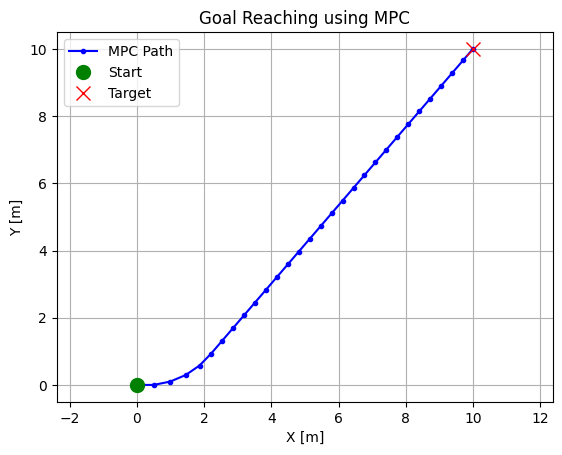

In [9]:
plt.figure()
plt.plot(path_x, path_y, "b-o", markersize=3, label="MPC Path")
plt.plot(start[0], start[1], "go", markersize=10, label="Start")
plt.plot(target[0], target[1], "rx", markersize=10, label="Target")
plt.title("Goal Reaching using MPC")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.show()

<hr>

# High-Level Interface: `Opti` Stack

The official doc does a reasonable job in explaining the Opti Stack: https://web.casadi.org/docs/#opti-stack

- `Opti` handles the vector flattening and indexing for us
- **Parameters**: We use `opti.parameter()` instead of `SX.sym`
- **Setting Values**: use `opti.set_value(p, value)` inside the loop instead of passing `p=...` to the solver
- **Warm-Start**: use `opti.set_initial(U, new_guess)` to update the guess for next iteration


In [10]:
opti = ca.Opti()

# Decision Variables: 2 rows (v, omega), N columns
U = opti.variable(2, N)
v, omega = U[0, :], U[1, :]

# Parameters: initial state changes every MPC iteration
P_start = opti.parameter(3)

# Initializing cost and symbolic state
curr_state = P_start
J = 0

# w_stage and w_goal weights (standard practice)
w_stage = 1.0
w_goal = 10.0

for k in range(N):
    # Stage Cost for current state x_k
    dist_sq = (curr_state[0] - target[0])**2 + (curr_state[1] - target[1])**2
    J += w_stage * dist_sq

    # update state
    u_k = U[:, k]
    dx = ca.vertcat(
        u_k[0] * ca.cos(curr_state[2]),
        u_k[0] * ca.sin(curr_state[2]),
        u_k[1]
    )
    curr_state = curr_state + dx * dt

# Terminal Cost
J += w_goal * ((curr_state[0] - target[0])**2 + (curr_state[1] - target[1])**2)

opti.minimize(J)

# Constraints and Solver
opti.subject_to(opti.bounded(-5, v, 5))
opti.subject_to(opti.bounded(-2, omega, 2))

opts = {
    "ipopt.print_level": 0,
    "print_time": False,
    "ipopt.tol": 1e-4,
    "ipopt.warm_start_init_point": "yes",
}
opti.solver("ipopt", opts)

### MPC Loop

In [11]:
curr_state = np.array(start)
path_x = [start[0]]
path_y = [start[1]]

# Initial Guess for controls
current_u_guess = np.zeros((2, N))

max_sim_steps = 200
for t in range(max_sim_steps):
    # update the parameter
    opti.set_value(P_start, curr_state)

    # warm start
    opti.set_initial(U, current_u_guess)

    sol = opti.solve()

    # Get optimal controls (matrix 2xN)
    u_opt = sol.value(U)

    # first control
    v_cmd = u_opt[0, 0]
    w_cmd = u_opt[1, 0]

    # warm start for next iteration
    next_u_guess = np.zeros((2, N))
    next_u_guess[:, :-1] = u_opt[:, 1:]
    current_u_guess = next_u_guess

    # simulate
    theta = curr_state[2]
    curr_state[0] += v_cmd * np.cos(theta) * dt
    curr_state[1] += v_cmd * np.sin(theta) * dt
    curr_state[2] += w_cmd * dt

    path_x.append(curr_state[0])
    path_y.append(curr_state[1])

    dist = np.sqrt((curr_state[0] - target[0]) ** 2 + (curr_state[1] - target[1]) ** 2)
    if dist < 0.1:
        break


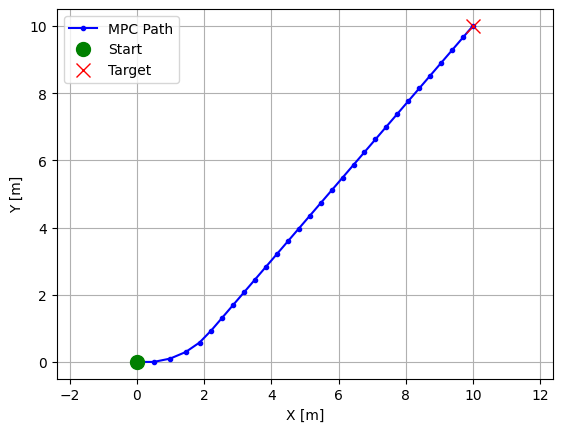

In [12]:
plt.figure()
plt.plot(path_x, path_y, "b-o", markersize=3, label="MPC Path")
plt.plot(start[0], start[1], "go", markersize=10, label="Start")
plt.plot(target[0], target[1], "rx", markersize=10, label="Target")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.show()